In [4]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import os

# Load Train and Validation from disk
They where splitted from train.csv after shuffling

In [5]:
df_train = pd.read_csv('train_splitted.csv')
df_valid = pd.read_csv('valid_splitted.csv')

X_train = df_train.drop(columns=['ID_code', 'target'])
X_valid = df_valid.drop(columns=['ID_code', 'target'])

y_train = df_train['target']
y_valid = df_valid['target']

# Normalization

In [6]:
# Calculate 
def get_stats(df_train, resolution = 501):
    means = df_train.drop(columns=['target', 'ID_code']).mean()
    stds = df_train.drop(columns=['target', 'ID_code']).std()
    mins = df_train.drop(columns=['target', 'ID_code']).min()
    maxs = df_train.drop(columns=['target', 'ID_code']).max()
    max_z_zcore = np.ceil(((maxs-means)/stds).max())
    min_z_zcore = np.floor(((mins-means)/stds).min())
    z_scores = np.linspace(min_z_zcore, max_z_zcore, resolution)
    return means, stds, min_z_zcore, max_z_zcore, z_scores

In [10]:
means, stds, min_z_zcore, max_z_zcore, z_scores = get_stats(df_train, resolution = 501)

In [11]:
N_vars = df_train.shape[1]-2
print('Number of independent variables:', N_vars)

Number of independent variables: 200


In [12]:
print('Z-score range is from {} to {}'.format(min_z_zcore, max_z_zcore))

Z-score range is from -5.0 to 5.0


# Bayes Theorem

Target = 1  
$\large P(t=1|V_0, V_1, ..., V_{199}) = \frac{P(V_0, V_1, ..., V_{199}|t=1)P(t=1)}{P(V_0,V_1, ..., V_{199})} \quad$

Target = 0  
$\large P(t=0|V_0, V_1, ..., V_{199}) = \frac{P(V_0, V_1, ..., V_{199}|t=0)P(t=0)}{P(V_0,V_1, ..., V_{199})} \quad$

# Naive Bayes

$\large \large P(t=1|V_0, V_1, ..., V_{199}) = \frac{P(V_0|t=1) P(V_1|t=1) ... P(V_{199}|t=1) P(t=1)}{P(V_0,...,V_{199})} \quad$ Independence of Conditionals

$\large \large P(t=0|V_0, V_1, ..., V_{199}) = \frac{P(V_0|t=0) P(V_1|t=0) ... P(V_{199}|t=0) P(t=0)}{P(V_0,...,V_{199})} \quad$ Independence of Conditionals

# Likelihoods calculation:

$\large P(V_i|t=1)$ and $\large P(V_i|t=0)$

In [13]:
# All the observation where target = 1
df_target_1 = df_train[df_train['target']==1]
# All the observation where target = 0
df_target_0 = df_train[df_train['target']==0]

In [14]:
def likelihoods_frequency(v, i=0, c=3, df_target_1=df_target_1, df_target_0=df_target_0):
    #
    # Counts the observations in region [v-stds[i]/c, v+stds[i]/c] for variable v_i and normalized it with the range
    # 
    """
    v: center of region
    i: variable index (var_i)
    c: smoothing for moving average
    """
    # From the observations where the target is 0 count the number of observations that are between v-stds[i]/c and v+stds[i]/c
    N_interval_0 = len(df_target_0[(df_target_0['var_'+str(i)]>v-stds[i]/c) &(df_target_0['var_'+str(i)]<v+stds[i]/c)])
    
    # From the observations where the target is 1 count the number of observations that are between v-stds[i]/c and v+stds[i]/c
    N_interval_1 = len(df_target_1[(df_target_1['var_'+str(i)]>v-stds[i]/c) &(df_target_1['var_'+str(i)]<v+stds[i]/c)])
    # Returns the estimation of the likelihood at v
    return N_interval_0/(2*stds[i]/c), N_interval_1/(2*stds[i]/c)

In [15]:
def get_pdf(var_i, means=means, stds=stds, z_scores=z_scores, smoothing=1, c=3, N_vars=N_vars, df_target_0=df_target_0, df_target_1=df_target_1):
    # Estimates the likelihood probability density function of variable v_i for all v_i's sample space
    """
    var_i: variable index
    c: smoothing for moving average
    smoothing: laplacian smoothing
    """
    ps_0 = []
    ps_1 = []
    N_0 = len(df_target_0) + smoothing*N_vars
    N_1 = len(df_target_1) + smoothing*N_vars
    for z in z_scores:
        # Unnormalize
        v = z*stds[var_i] + means[var_i]
        l0, l1 = likelihoods_frequency(v, var_i, c=c)
        ps_0.append(l0 + smoothing)
        ps_1.append(l1 + smoothing)
    return np.array(ps_0)/N_0, np.array(ps_1)/N_1

CPU times: user 4.01 s, sys: 260 ms, total: 4.27 s
Wall time: 4.27 s


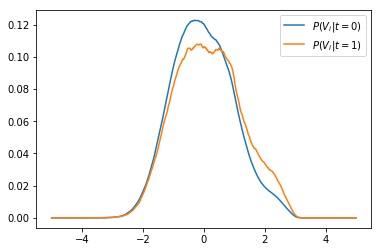

In [17]:
var_i = 0
%time l0_3,l1_3 = get_pdf(var_i, c=3)
plt.plot(z_scores, l0_3, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_3, label='$P(V_i|t=1)$')
plt.legend()
plt.show()

### Effect of moving average smoothing

CPU times: user 9.99 s, sys: 7.24 s, total: 17.2 s
Wall time: 17.2 s


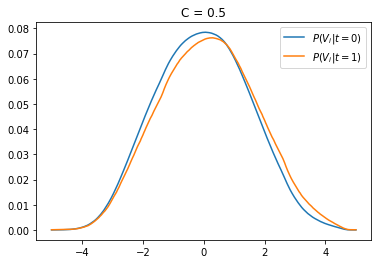

In [18]:
%time l0_05,l1_05 = get_pdf(var_i, c=0.5)
plt.plot(z_scores, l0_05, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_05, label='$P(V_i|t=1)$')
plt.title('C = 0.5')
plt.legend()
plt.show()

CPU times: user 2.54 s, sys: 2.3 ms, total: 2.54 s
Wall time: 2.54 s


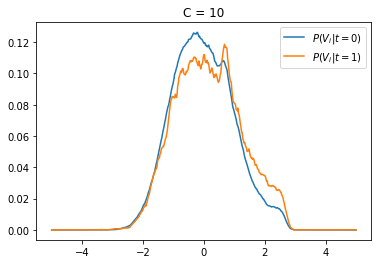

In [19]:
%time l0_10,l1_10 = get_pdf(var_i, c=10)
plt.plot(z_scores, l0_10, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_10, label='$P(V_i|t=1)$')
plt.title('C = 10')
plt.legend()
plt.show()

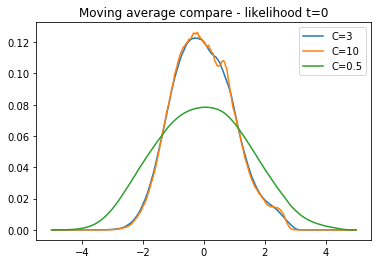

In [20]:
plt.plot(z_scores, l0_3, label='C=3')
plt.plot(z_scores, l0_10, label='C=10')
plt.plot(z_scores, l0_05, label='C=0.5')
plt.title('Moving average compare - likelihood t=0')
plt.legend()
plt.show()

# Efect of laplacian smoothing

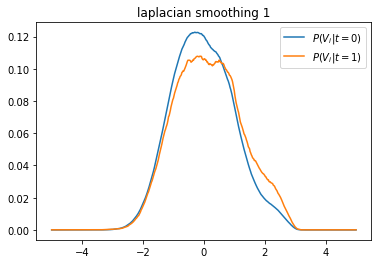

In [21]:
l0_ls1, l1_ls1 = get_pdf(var_i, c=3, smoothing=1)
plt.plot(z_scores, l0_ls1, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_ls1, label='$P(V_i|t=1)$')
plt.title('laplacian smoothing 1')
plt.legend()
plt.show()

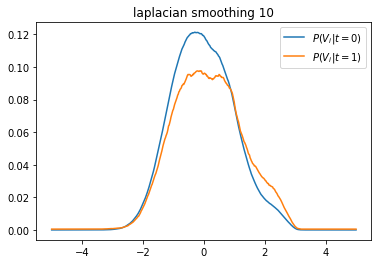

In [22]:
l0_ls10, l1_ls10 = get_pdf(var_i, c=3, smoothing=10)
plt.plot(z_scores, l0_ls10, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_ls10, label='$P(V_i|t=1)$')
plt.title('laplacian smoothing 10')
plt.legend()
plt.show()

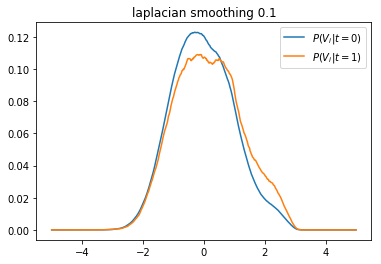

In [23]:
l0_ls01, l1_ls01 = get_pdf(var_i, c=3, smoothing=0.1)
plt.plot(z_scores, l0_ls01, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_ls01, label='$P(V_i|t=1)$')
plt.title('laplacian smoothing 0.1')
plt.legend()
plt.show()

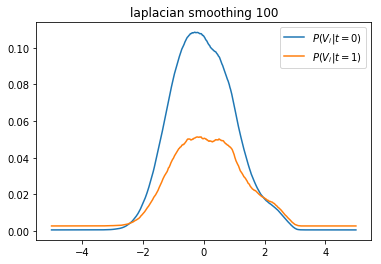

In [24]:
l0_ls100, l1_ls100 = get_pdf(var_i, c=3, smoothing=100)
plt.plot(z_scores, l0_ls100, label='$P(V_i|t=0)$')
plt.plot(z_scores, l1_ls100, label='$P(V_i|t=1)$')
plt.title('laplacian smoothing 100')
plt.legend()
plt.show()

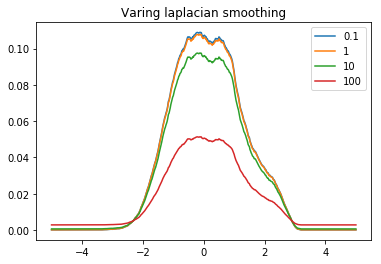

In [25]:
plt.plot(z_scores, l1_ls01, label='0.1')
plt.plot(z_scores, l1_ls1, label='1')
plt.plot(z_scores, l1_ls10, label='10')
plt.plot(z_scores, l1_ls100, label='100')
plt.title('Varing laplacian smoothing')
plt.legend()
plt.show()

# Odds
$\large \frac{P(t=1|V_0, V_1, ..., V_{199})}{P(t=0|V_0, V_1, ..., V_{199})} > 1\quad$ implies that target 1 is more probable than target 0 

Doing the quotient from Naive Bayes

$\huge \frac{\frac{P(V_0|t=1) P(V_1|t=1) ... P(V_{199}|t=1) P(t=1)}{P(V_0,...,V_{199})}}{\frac{P(V_0|t=0) P(V_1|t=0) ... P(V_{199}|t=0) P(t=0)}{P(V_0,...,V_{199})}} = \frac{P(V_0|t=1) P(V_1|t=1) ... P(V_{199}|t=1) P(t=1)}{P(V_0|t=0) P(V_1|t=0) ... P(V_{199}|t=0) P(t=0)}$

### Odds for one variable
$\large \frac{P(V_1|t=1)P(t=1)}{P(V_1|t=0)P(t=0)}$


In [26]:
# Odds for just one variable
# P(t=1) is the estimated as the proportion of observations with target 1
# P(t=0) is the estimated as the proportion of observations with target 0
p_1 = len(df_target_1)/len(df_train)
p_0 = len(df_target_0)/len(df_train)
print(p_1, p_0)

0.1002875 0.8997125


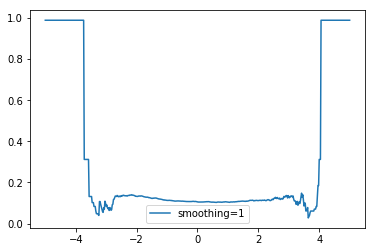

In [28]:
var_i = 50
l0,l1 = get_pdf(var_i, c=3, smoothing=1)
odds_ls_1 = l1/l0 * p_1/p_0
plt.plot(z_scores, odds_ls_1, label='smoothing=1')
plt.legend()
plt.show()

### Effect of laplacian smoothing

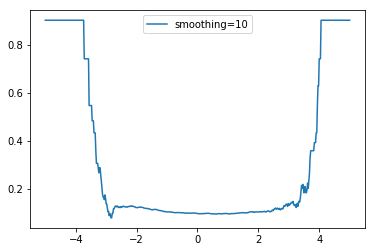

In [29]:
l0,l1 = get_pdf(var_i, c=3, smoothing=10)
odds_ls10 = l1/l0 * p_1/p_0
plt.plot(z_scores, odds_ls10, label='smoothing=10')
plt.legend()
plt.show()

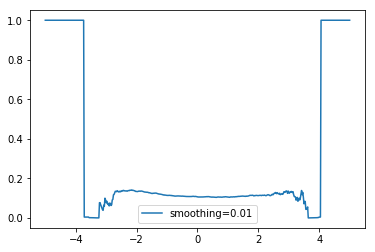

In [30]:
l0,l1 = get_pdf(var_i, c=3, smoothing=0.01)
odds_ls01 = l1/l0 * p_1/p_0
plt.plot(z_scores, odds_ls01, label='smoothing=0.01')
plt.legend()
plt.show()

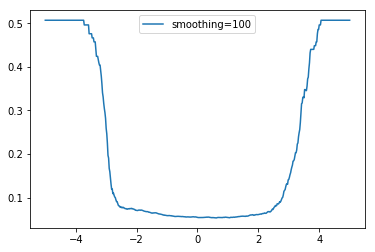

In [31]:
l0,l1 = get_pdf(var_i, c=3, smoothing=100)
odds_ls100 = l1/l0 * p_1/p_0
plt.plot(z_scores, odds_ls100, label='smoothing=100')
plt.legend()
plt.show()

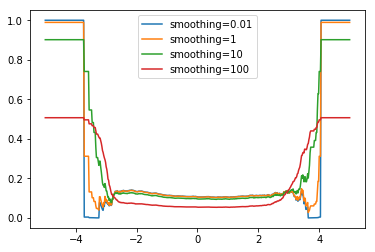

In [34]:
plt.plot(z_scores, odds_ls01, label='smoothing=0.01')
plt.plot(z_scores, odds_ls_1, label='smoothing=1')
plt.plot(z_scores, odds_ls10, label='smoothing=10')
plt.plot(z_scores, odds_ls100, label='smoothing=100')
plt.legend()
plt.show()

# Calculate marginal likelihoods for all $V_i$s
$P(V_0|t=1), P(V_1|t=1), ..., P(V_{199}|t=1)$

$P(V_0|t=0), P(V_1|t=0), ..., P(V_{199}|t=0)$

The two functions above: get_pdf and likelihoods_frequency, are inefficient but are easier to understand how the calculations are done. It takes almost 10 seconds in a pentium 7 with 12 processors and 16GB of memory when c=1

Doing calculations of 200 variables it takes aprox 10s*200/60 = 33 minutes

## First: choose c and laplacian smoothing

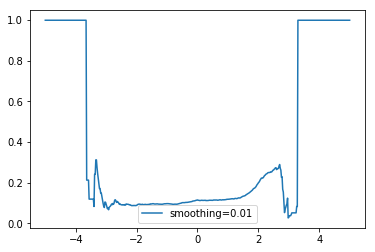

In [35]:
# Chossen c and smoothing
c = 3
smoothing = 1
l0,l1 = get_pdf(1, c=3, smoothing=0.1)
odds = l1/l0 * p_1/p_0
plt.plot(z_scores, odds, label='smoothing=0.01')
plt.legend()
plt.show()

## Second: calculate al V_i's

In [36]:
####
# In a pentium 7 with 12 processors and 16GB of memory
####
# For c=3
# CPU times: user 13min 34s, sys: 103 ms, total: 13min 34s
# Wall time: 13min 34s
####
# For c=0.5
# CPU times: user 32min 46s, sys: 22min 14s, total: 55min 1s
# Wall time: 55min 1s
####

def calculate_all_V_i_inefficient(df_train=df_train, smoothing=smoothing, c=c):
    # Check is the file is already in disk, if not calculate it and save it to disk

    filename_l0 = 'likelihood_matrix_0_smooth_{}_c_{}_{}.npy'.format(smoothing, c, len(df_train))
    filename_l1 = 'likelihood_matrix_1_smooth_{}_c_{}_{}.npy'.format(smoothing, c, len(df_train))

    if os.path.isfile(filename_l0) and os.path.isfile(filename_l1):
        likelihood_matrix_0_np = np.load(filename_l0)
        likelihood_matrix_1_np = np.load(filename_l1)
        print('Skip likelihoods calculations, files {} and {} already exists'.format(filename_l0, filename_l1))
    else:
        likelihood_matrix_0 = []
        likelihood_matrix_1 = []
        for i in range(df_train.shape[1] - 2):
            # This for is very inefficient because it calculates each variable separately
            print('\rCalculating likelihoods for var_'+str(i), end="")
            var_i_0, var_i_1 = get_pdf(i, smoothing=smoothing, c=c)
            likelihood_matrix_0.append(var_i_0)
            likelihood_matrix_1.append(var_i_1)
        # To numpy    
        likelihood_matrix_0_np = np.array(likelihood_matrix_0).T
        likelihood_matrix_1_np = np.array(likelihood_matrix_1).T
        # Save them
        np.save(filename_l0, likelihood_matrix_0_np)
        np.save(filename_l1, likelihood_matrix_1_np)

    # The odds here is not multiplied by p_1/p_0, it will be done later
    odds = likelihood_matrix_1_np/likelihood_matrix_0_np
    filename_odds = 'odds_smooth_{}_c_{}_{}.npy'.format(smoothing, c, len(df_train))
    np.save(filename_odds, odds)
    print()
    return likelihood_matrix_0_np, likelihood_matrix_1_np, odds

In [40]:
## Uncomment to try it
# %time likelihood_matrix_0, likelihood_matrix_1, odds = calculate_all_V_i_inefficient(df_train=df_train, smoothing=smoothing, c=c)
# var_i = 0
# plt.plot(z_scores, likelihood_matrix_0[:,var_i])
# plt.plot(z_scores, likelihood_matrix_1[:,var_i])
# plt.show()

### Vectorization to accelarate processing

In [37]:
####
# In a pentium 7 with 12 processors and 16GB of memory
####
# For c=3
# CPU times: user 2min 36s, sys: 51.3 s, total: 3min 27s
# Wall time: 3min 27s
####
# For c=0.5
# CPU times: user 2min 55s, sys: 51.7 s, total: 3min 46s
# Wall time: 3min 46s
####
def likelihoods_frequency_vect(v, c=3, df_target_1=df_target_1, df_target_0=df_target_0):
    # This version calculates all variables v_i in one shot
    N_interval_0 = ((df_target_0.drop(columns=['ID_code', 'target'])>v-stds/c) 
                    & (df_target_0.drop(columns=['ID_code', 'target'])<v+stds/c)).sum(axis=0)
    N_interval_1 = ((df_target_1.drop(columns=['ID_code', 'target'])>v-stds/c) 
                    & (df_target_1.drop(columns=['ID_code', 'target'])<v+stds/c)).sum(axis=0)
    return N_interval_0/(2*stds/c), N_interval_1/(2*stds/c)

def get_pdf_vect(means=means, stds=stds, z_scores=z_scores, smoothing=1, c=3, df_target_1=df_target_1, df_target_0=df_target_0):
    # Calculates the probability density function of all V_is
    # Same as calculate_all_V_i_inefficient but in a more efficient way
    """
    var_i: variable index
    c: smoothing for moving average
    smoothing: laplacian smoothing
    """
    N_0 = len(df_target_0) + smoothing*N_vars
    N_1 = len(df_target_1) + smoothing*N_vars
    ps_0 = []
    ps_1 = []
    for z in z_scores:
        print('\r z =', z, end = '')
        # Unnormalize
        v = z*stds + means
        l0, l1 = likelihoods_frequency_vect(v, c=c)
        ps_0.append(l0 + smoothing)
        ps_1.append(l1 + smoothing)
    likelihood_matrix_0 = np.array(ps_0)/N_0
    likelihood_matrix_1 = np.array(ps_1)/N_1
    odds = likelihood_matrix_1/likelihood_matrix_0
    print()
    return likelihood_matrix_0, likelihood_matrix_1, odds

In [39]:
## Uncomment to try it
# %time likelihood_matrix_0, likelihood_matrix_1, odds = get_pdf_vect(smoothing=smoothing, c=c)
# var_i = 0
# plt.plot(z_scores, likelihood_matrix_0[:,var_i])
# plt.plot(z_scores, likelihood_matrix_1[:,var_i])
# plt.show()

### Multiprocessing  

In [41]:
from multiprocessing import Pool
from functools import partial

In [6]:
####
# In a pentium 7 with 12 processors and 16GB of memory
####
# For c=3
# CPU times: user 91.6 ms, sys: 144 ms, total: 235 ms
# Wall time: 48.7 s
####
# For c=0.5
# CPU times: user 80.2 ms, sys: 142 ms, total: 222 ms
# Wall time: 48.3 s
####

def get_pdf_vect_parallel(z_scores_interval, means=means, stds=stds, smoothing=1, c=3, df_target_1=df_target_1, df_target_0=df_target_0):
    # Calculates the probability density function of variable v_i for all v's
    """
    var_i: variable index
    c: smoothing for moving average
    smoothing: laplacian smoothing
    """
    N_0 = len(df_target_0) + smoothing*N_vars
    N_1 = len(df_target_1) + smoothing*N_vars
    ps_0 = []
    ps_1 = []
    for z in z_scores_interval:
        # Unnormalize
        v = z*stds + means
        l0, l1 = likelihoods_frequency_vect(v, c=c, df_target_1=df_target_1, df_target_0=df_target_0)
        ps_0.append(l0 + smoothing)
        ps_1.append(l1 + smoothing)
    return np.array(ps_0)/N_0, np.array(ps_1)/N_1



def train_parallel(df_train, N = 10, smoothing=1, c=3, resolution=501):
    means, stds, min_z_zcore, max_z_zcore, z_scores = get_stats(df_train, resolution = resolution)
    # All the observation where target = 1
    df_target_1 = df_train[df_train['target']==1]
    # All the observation where target = 0
    df_target_0 = df_train[df_train['target']==0]
    
    N_paral = int(len(z_scores)/N)
    z_scores_list = []
    for i in range(N):
        z_scores_min = i*N_paral
        if i == N-1:
            z_scores_max = len(z_scores)
        else:
            z_scores_max = (i+1)*N_paral
        z_scores_list.append(list(z_scores[z_scores_min: z_scores_max]))
    likelihoods_pdfs = []
    with Pool(N) as p:
        likelihoods_pdfs = p.map(partial(get_pdf_vect_parallel, smoothing=smoothing, c=c), z_scores_list)
    likelihood_matrix_0 = np.empty((0, 200))
    likelihood_matrix_1 = np.empty((0, 200))
    for i, (l0, l1) in enumerate(likelihoods_pdfs):
        likelihood_matrix_0 = np.append(likelihood_matrix_0, l0, axis=0)
        likelihood_matrix_1 = np.append(likelihood_matrix_1, l1, axis=0)
    odds = likelihood_matrix_1/likelihood_matrix_0
    p_1 = len(df_target_1)/len(df_train)
    p_0 = len(df_target_0)/len(df_train)
    return likelihood_matrix_0, likelihood_matrix_1, odds, p_1, p_0, means, stds, z_scores

%time likelihood_matrix_0, likelihood_matrix_1, odds, p_1, p_0, means, stds, z_scores = train_parallel(df_train, N = 10, smoothing=smoothing, c=c)

NameError: name 'means' is not defined

### Plot likelihoods

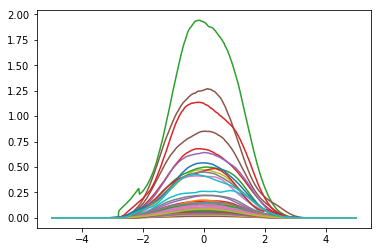

In [44]:
plt.plot(z_scores, likelihood_matrix_0[:,:60])
plt.show()

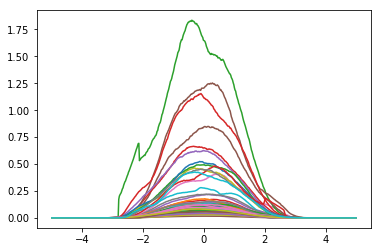

In [45]:
plt.plot(z_scores, likelihood_matrix_1[:,:60])
plt.show()

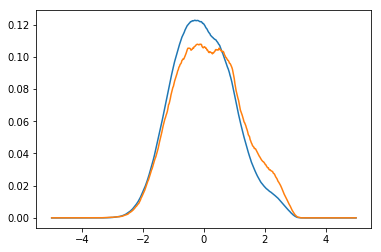

In [46]:
var_i = 0
plt.plot(z_scores, likelihood_matrix_0[:,var_i])
plt.plot(z_scores, likelihood_matrix_1[:,var_i])
plt.show()

### Plot odds

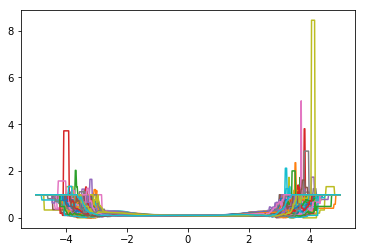

In [47]:
plt.plot(z_scores, odds * p_1/p_0)
plt.show()

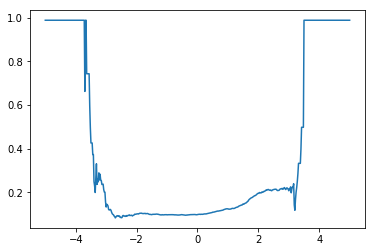

In [48]:
plt.plot(z_scores, odds[:,0] * p_1/p_0)
plt.show()

# Estimate Observations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from NaiveBayesPDF import NaiveBayesPDF
from matplotlib import pyplot as plt

## Train model (160.000 observations)

In [3]:
df_train = pd.read_csv('train_splitted.csv')

In [4]:
NBpdf = NaiveBayesPDF(smoothing=1, c=3, resolution=501, N_processors=10)
%time NBpdf.fit(df_train)

In [6]:
NBpdf.p_0_, NBpdf.p_1_

(0.8997125, 0.1002875)

In [7]:
NBpdf.odds_.shape

(501, 200)

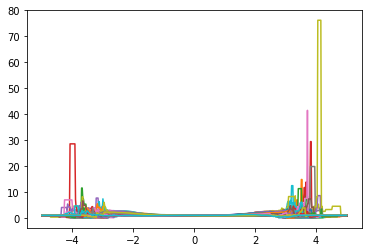

In [8]:
var_j = 1
plt.plot(NBpdf.z_scores_, NBpdf.odds_)
plt.show()

In [9]:
observations_normalized, observations_odds, log_odds, prod_odds, probs, auc_train, acc_train = \
    NBpdf.predict(df_train.drop(columns=['target', 'ID_code']).values, df_train['target'].values)

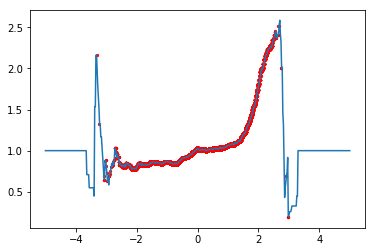

0.9061337772130391 0.9261875


In [10]:
var_j = 1
plt.plot(NBpdf.z_scores_, NBpdf.odds_[:,var_j])
plt.scatter(observations_normalized[:,var_j], observations_odds[:,var_j], s=20, marker='.', c='red')
plt.show()
print(auc_train, acc_train)

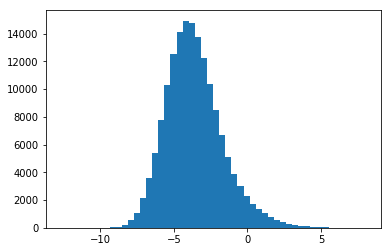

In [11]:
_ = plt.hist(log_odds, 50)

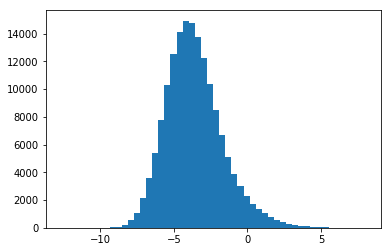

In [12]:
_ = plt.hist(log_odds, 50)

In [13]:
import pickle
pickle.dump(NBpdf, open('naive_bayes_pdf_train_only.pk', 'wb'))

# Validation

In [14]:
df_valid = pd.read_csv('valid_splitted.csv')

In [33]:
_, _, log_odds_valid, _, probs_valid, auc_valid, acc_valid = \
    NBpdf.predict(df_valid.drop(columns=['target', 'ID_code']).values, df_valid['target'].values)

ValueError: operands could not be broadcast together with shapes (40000,200) (400,) 

In [16]:
print(auc_valid, acc_valid)

0.9038649429564323 0.924425


In [17]:
max(probs_valid)

0.9994338695391691

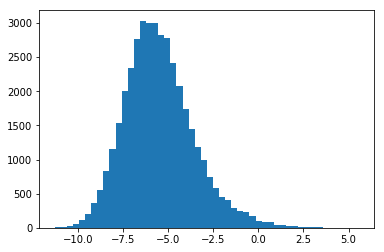

In [18]:
_ = plt.hist(log_odds_valid, 50)

# More features

In [53]:
df_train = pd.read_csv('train_splitted.csv')

In [54]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
119737,train_119737,0,11.0038,-4.5026,9.0662,6.4313,10.7061,-15.2857,5.1233,16.7875,...,-0.8200,3.3085,3.1358,5.0959,19.7160,-0.1801,5.8437,8.8348,17.0461,8.8190
72272,train_72272,0,12.8473,-6.1848,6.8799,2.0164,12.7998,10.2781,4.4191,15.6940,...,1.1516,3.9019,4.6616,7.6035,12.6402,-0.3037,-4.2330,9.7456,14.8337,-3.7167
158154,train_158154,0,13.1827,-0.8344,13.4689,3.9060,13.5984,4.6475,5.9659,24.0557,...,2.8737,5.8939,0.8525,8.7406,16.6641,0.8745,7.0406,8.6424,20.7107,-5.4186
65426,train_65426,0,8.2132,1.2309,11.1464,9.4524,10.2142,4.0416,5.3989,20.4527,...,6.4752,5.7442,2.1907,6.0651,10.9444,-2.0666,-7.9209,9.0522,17.1735,12.4656
30074,train_30074,1,5.5681,4.6355,15.2350,3.0718,11.8178,-15.0502,3.8357,12.0169,...,4.1796,5.6113,-0.1561,3.1010,17.4297,-1.0121,-6.5168,7.9772,18.5248,11.2771


In [55]:
N = df_train.shape[1]-2
for i in range(N):
    df_train['var_'+str(N+i)] = pd.Series(df_train['var_'+str(i)]**2/100, index=df_train.index)

In [56]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_390,var_391,var_392,var_393,var_394,var_395,var_396,var_397,var_398,var_399
119737,train_119737,0,11.0038,-4.5026,9.0662,6.4313,10.7061,-15.2857,5.1233,16.7875,...,0.006724,0.109462,0.098332,0.259682,3.887207,0.000324,0.341488,0.780537,2.905695,0.777748
72272,train_72272,0,12.8473,-6.1848,6.8799,2.0164,12.7998,10.2781,4.4191,15.6940,...,0.013262,0.152248,0.217305,0.578132,1.597747,0.000922,0.179183,0.949767,2.200387,0.138139
158154,train_158154,0,13.1827,-0.8344,13.4689,3.9060,13.5984,4.6475,5.9659,24.0557,...,0.082582,0.347381,0.007268,0.763981,2.776922,0.007648,0.495700,0.746911,4.289331,0.293612
65426,train_65426,0,8.2132,1.2309,11.1464,9.4524,10.2142,4.0416,5.3989,20.4527,...,0.419282,0.329958,0.047992,0.367854,1.197799,0.042708,0.627407,0.819423,2.949291,1.553912
30074,train_30074,1,5.5681,4.6355,15.2350,3.0718,11.8178,-15.0502,3.8357,12.0169,...,0.174691,0.314867,0.000244,0.096162,3.037944,0.010243,0.424687,0.636357,3.431682,1.271730


In [ ]:
NBpdf = NaiveBayesPDF(smoothing=1, c=3, resolution=501, N_processors=10)
%time NBpdf.fit(df_train)

In [29]:
NBpdf.odds_.shape

(501, 400)

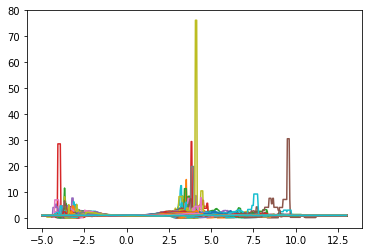

In [30]:
var_j = 1
plt.plot(NBpdf.z_scores_, NBpdf.odds_)
plt.show()

In [31]:
observations_normalized, observations_odds, log_odds, prod_odds, probs, auc_train, acc_train = \
    NBpdf.predict(df_train.drop(columns=['target', 'ID_code']).values, df_train['target'].values)

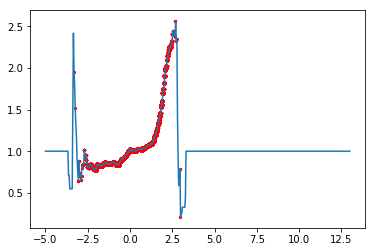

0.9001811268699023 0.9197


In [32]:
var_j = 1
plt.plot(NBpdf.z_scores_, NBpdf.odds_[:,var_j])
plt.scatter(observations_normalized[:,var_j], observations_odds[:,var_j], s=20, marker='.', c='red')
plt.show()
print(auc_train, acc_train)

# Validation sqr

In [41]:
df_valid = pd.read_csv('valid_splitted.csv')

In [42]:
for i in range(N):
    df_valid['var_'+str(N+i)] = pd.Series(df_valid['var_'+str(i)]**2/100, index=df_valid.index)

In [48]:
_, _, log_odds_valid, _, probs_valid, auc_valid, acc_valid = \
    NBpdf.predict(df_valid.drop(columns=['target', 'ID_code']).values, df_valid['target'].values)

In [49]:
print(auc_valid, acc_valid)

0.8963581513101463 0.915525


# Retrain with full dataset

In [398]:
df_train = pd.read_csv('train.csv')

In [275]:
_, _, odds, p_1, p_0, means, stds, z_scores = train_parallel(df_train, N = 10, smoothing=1, c=3, resolution=501)

In [280]:
observations_normalized_full, observations_odds_full, log_odds_full, prod_odds_full, auc_full = \
    predict(df_train, odds, p_1, p_0, means, stds, z_scores)

In [281]:
print('Validation AUC = {}, for c={} and smothing={}'.format(auc_full, c, smoothing))

Validation AUC = 0.9049136673574159, for c=3 and smothing=1


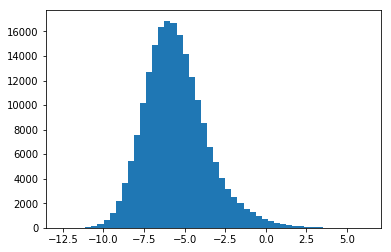

In [399]:
_ = plt.hist(log_odds_full, 50)

In [283]:
(prod_odds_full>=1).sum()

2088

# Test

In [400]:
df_test = pd.read_csv('test.csv')

In [408]:
_, _, log_odds_full, prod_odds_test, _, _ = predict(df_test, odds, p_1, p_0, means, stds, z_scores)

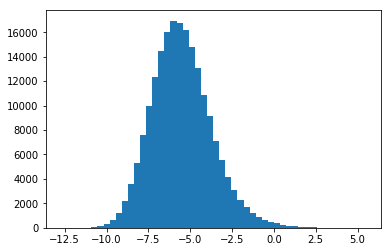

In [409]:
_ = plt.hist(log_odds_full, 50)

In [410]:
import time

In [421]:
filename = 'submission_bayes_smooth_{}_c_{}_{}.csv'.format(smoothing, c, int(time.time()))

In [423]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = prod_odds_test
sub.to_csv(filename,index=False)

In [ ]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f {filename} -m "submission_bayes_3"

In [424]:
! ls *.csv

lgb_all_predictions.csv
lgb_oof.csv
lgb_submission_0.csv
lgb_submission_1.csv
sample_submission.csv
submission_0.8615885372698715.csv
submission_0.8639528713193811.csv
submission_0.864849032756072.csv
submission_bayes_kaggle.csv
submission_bayes_smooth_1_2nd_submit.csv
submission_bayes_smooth_1_3rd_submit_0_75_c_2_5_200000.csv
submission_bayes_smooth_1_c_2_200000_cube.csv
submission_bayes_smooth_1_c_3_1553631332.csv
submission_bayes_smooth_1.csv
test.csv
train.csv
